# Simulation for Data Setup

We use a simulation implemented in Anylogic 8.1 to check our implementation is correct. The generative process can be summarized in the figure below: 

![model](model.png)

Using life table age-specific mortality rates, the U.S. age population distribution, and a constant imprisonment rate equals to 0.007 between ages 18 and 45, otherwise that rate is 0. Being in prison increases age-specific mortality rates by 1.90. 

We generated 1000 samples using 10,000 individuals. Individuals enter to the observation window at different ages (based on the U.S. age distribution) and  right censoring is defined using a uniform distribution (`censoring = uniform(age_enter, 120)`)


In [3]:
library(sdazar)
library(survival)
library(texreg)
library(eha)

dat <- fread('output.csv')

Read 10000000 rows and 6 (of 6) columns from 0.655 GB file in 00:00:18


I run 1000 Cox models adjusting by a time-varying prison variable (only 1s after the incarceration transition occurs), that is, there is a split in the data when incarceration takes place, and I also adjust by age (start and stop times represent the observation window, not age, as in our analysis of PSID and NLSY). The key event is death. Below an example of the data setup.

In [26]:
head(dat)

rep,id,agedeath,ageprison,enter,censored
1,6561,69.76973,0,69.75889,102.26383
1,6604,19.75309,0,19.72718,119.36324
1,1829,82.16374,0,82.11544,106.13487
1,1070,61.80797,0,61.74163,65.58724
1,9490,87.86229,0,87.78112,96.70979
1,7421,30.09042,0,29.99795,50.57497


In [17]:
coefb <- NULL
coefvar <- NULL
coefvar_noage <- NULL
coefnvar <- NULL

maxrep <- max(dat$rep)

for (i in 1:maxrep) {
  
 sdat <- dat[rep == i]
 sdat[ageprison < agedeath, prison := ifelse(ageprison > 0, 1, 0)]
 table(sdat$prison)
 sdat[, stop := agedeath]
 sdat[, start := 0]
 
 sdat[, event := 1]
 sdat[, count := ifelse(prison > 0, 2, 1)]
 sdat <- sdat[rep(seq(1, nrow(sdat)), sdat$count)] # expand data
 sdat[, s := 1:.N, id]
 
 sdat[count == 1, vprison := 0]
 sdat[count == 2 & s == 1, stop := ageprison]
 sdat[count == 2 & s == 2, start := ageprison]
 sdat[count == 2 & s == 2, vprison := 1]
 sdat[count == 2 & s == 1, vprison := 0]
 sdat[event == 1 & count == 2 & s == 1, event := 0]
 sdat[count == 2]
 
 m0 <- coxph(Surv(start, stop, event) ~ vprison, data = sdat) 
 coefb <- c(coefb, exp(coef(m0)[1]))
 
 tdat <- dat[rep == i]  
 tdat[ageprison < censored | ageprison < agedeath, anyprison := ifelse(ageprison > 0, 1,0)]
 tdat[, exit := ifelse(agedeath > censored, censored, agedeath)]
 tdat[ageprison > exit, ageprison := 0]
 tdat[ageprison < enter, ageprison := 0] # under estimation
 tdat[, select := ifelse(exit > enter, 1, 0)] # only if death occured before death
 tdat[, event := ifelse(agedeath == exit, 1, 0)] # deaths
 tdat <- tdat[select == 1]
 tdat[, prison := ifelse(ageprison > 0, 1, 0)] # people with prison experiences

 tdat[, age := enter]
 tdat[, start := 0]
 tdat[, stop := exit - enter] # observation time
 tdat[ageprison > 0, tprison := ageprison - enter] # observation time for prison
 
 # split dataset
 tdat[, count := ifelse(ageprison > 0, 2, 1)]
 tdat <- tdat[rep(seq(1, nrow(tdat)), tdat$count)] # expand data
 tdat[, s := 1:.N, id]
 
 tdat[count == 1, vprison := 0]
 tdat[count == 2 & s == 1, stop := tprison]
 tdat[count == 2 & s == 2, start := tprison]
 tdat[count == 2 & s == 2, vprison := 1]
 tdat[count == 2 & s == 1, vprison := 0]
 tdat[event == 1 & count == 2 & s == 1, event := 0]
 
 m1 <- coxph(Surv(start, stop, event) ~ vprison + age, data = tdat) 
 coefvar <- c(coefvar,exp(coef(m1)[1]))
    
 m2 <- coxph(Surv(start, stop, event) ~ vprison, data = tdat) 
 coefvar_no_age  <- c(coefvar,exp(coef(m1)[1]))
    
    
 m3 <- coxph(Surv(start, stop, event) ~ prison + age, data = tdat) 
 coefnvar <- c(coefnvar, exp(coef(m2)[1]))

}

[1] 1.878656

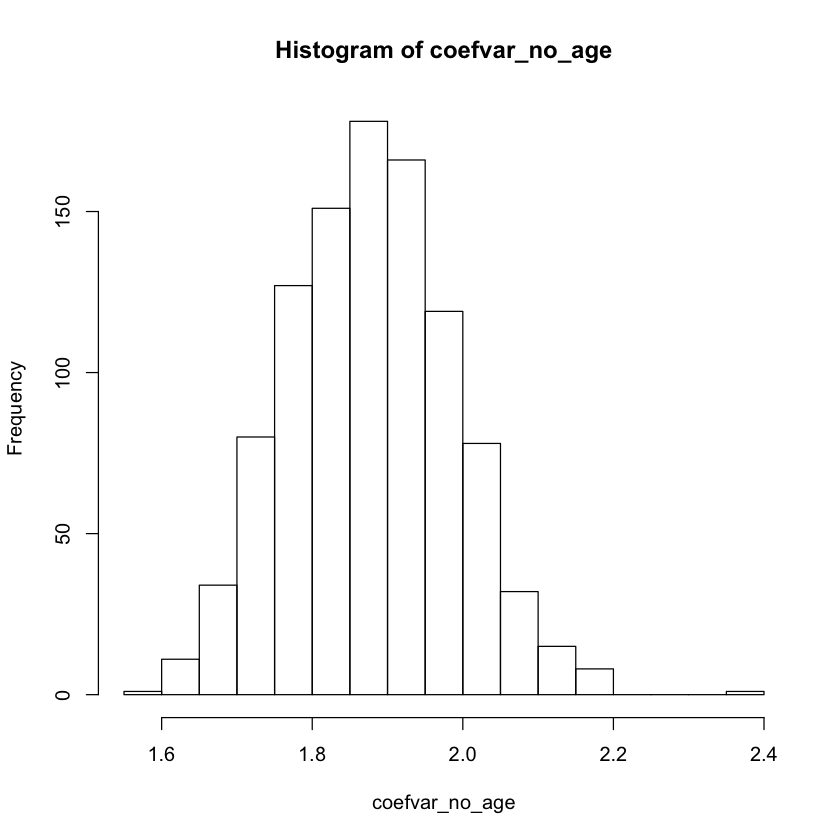

In [24]:
hist(coefvar_no_age)
mean(coefvar_no_age)

[1] 1.877508

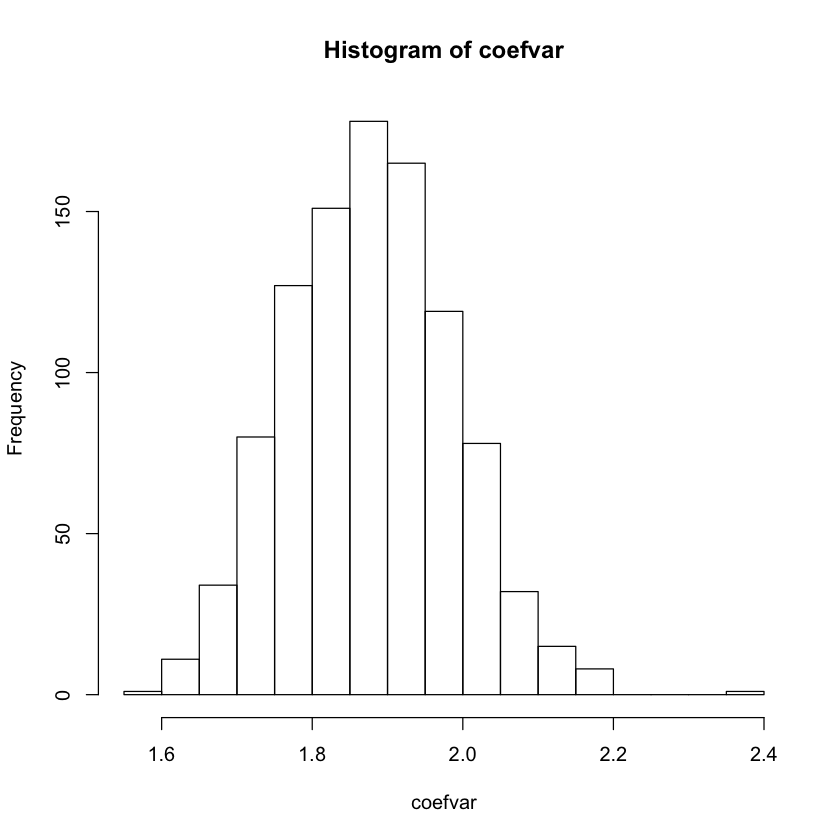

In [25]:
hist(coefvar)
median(coefvar)

[1] 1.825242

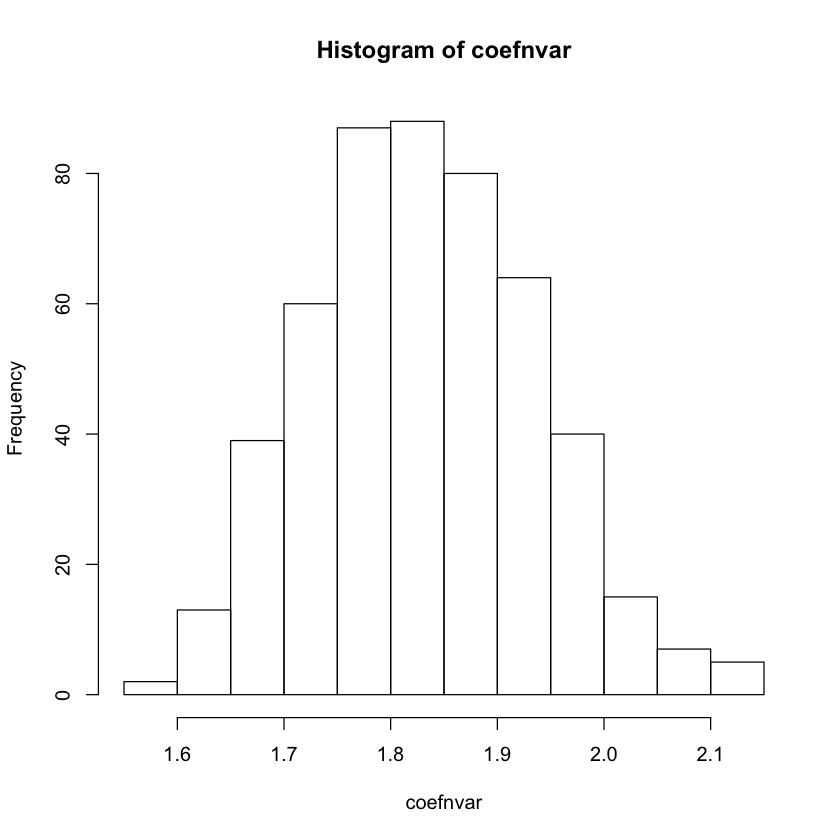

In [7]:
hist(coefnvar)
median(coefnvar)

In [8]:
dat[rep == i]

rep,id,agedeath,ageprison,enter,censored
500,2843,86.61749,0,86.60300,116.68277
500,8553,76.61279,0,76.57714,82.27243
500,7313,88.82592,0,88.77119,99.93564
500,5181,99.73750,0,99.68236,113.62640
500,2362,72.39357,0,72.33016,113.62633
500,967,26.31502,0,26.24920,50.18693
500,610,90.24082,0,90.16612,91.01445
500,7800,88.62738,0,88.55118,118.95172
500,5660,75.98303,0,75.89890,87.51392
500,4822,47.46078,0,47.36833,94.55175


In [13]:
setorder(tdat, id)

In [14]:
tdat

rep,id,agedeath,ageprison,enter,censored,anyprison,exit,select,event,prison,age,start,stop,tprison,count,s,vprison
500,1,98.25858,0.00000,76.757130,87.29552,0,87.29552,1,0,0,76.757130,0.000000,10.538386,NA,1,1,0
500,2,94.43036,0.00000,37.551121,108.32335,0,94.43036,1,1,0,37.551121,0.000000,56.879238,NA,1,1,0
500,3,79.46263,0.00000,70.725349,92.00496,0,79.46263,1,1,0,70.725349,0.000000,8.737283,NA,1,1,0
500,4,89.15745,0.00000,70.524895,108.18737,0,89.15745,1,1,0,70.524895,0.000000,18.632557,NA,1,1,0
500,5,80.15316,40.46245,32.106894,105.46053,1,80.15316,1,0,1,32.106894,0.000000,8.355559,8.355559,2,1,0
500,5,80.15316,40.46245,32.106894,105.46053,1,80.15316,1,1,1,32.106894,8.355559,48.046263,8.355559,2,2,1
500,6,94.43930,0.00000,42.206005,94.20835,0,94.20835,1,0,0,42.206005,0.000000,52.002349,NA,1,1,0
500,7,91.43278,0.00000,89.900560,98.73881,0,91.43278,1,1,0,89.900560,0.000000,1.532221,NA,1,1,0
500,8,79.58726,40.38953,7.977558,67.67676,1,67.67676,1,0,1,7.977558,0.000000,32.411969,32.411969,2,1,0
500,8,79.58726,40.38953,7.977558,67.67676,1,67.67676,1,0,1,7.977558,32.411969,59.699206,32.411969,2,2,1
